In [1]:
from PIL import Image, ImageFile,UnidentifiedImageError, ImageEnhance,ImageOps
import matplotlib.pyplot as plt
from facenet_pytorch import InceptionResnetV1, MTCNN
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.stats import skew
import random
import torch
import os
import numpy as np
import umap
import seaborn as sns
import pickle
import random

c:\Users\Loc\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# FACE_RECOGNITION

----------------------------------------------------------------------------------------------------------------------


STEP 1: Problem Understanding 

- Bài toán: Nhận diện khuôn mặt người dùng từ ảnh có sẵn.

- Loại bài toán: Phân loại .

- Đầu vào: (features) Các ảnh khuôn mặt người được tổ chức theo tên thư mục (cũng là tên của người đó).

- Output : (target) tên của người được nhận dạng (label) và tỉ lệ chính xác của nó.

- Mục tiêu: Xác định danh tính người trong ảnh, hoặc phát hiện người không có trong tập huấn luyện (Unknown).

In [2]:
# Cấu trúc thư mục đầu vào:

dataset_path = 'C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset'  
print("Cấu trúc của dataset:") 
print("\ndataset/")

for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if os.path.isdir(person_path):
        print(f" {person}/")
        img_list = os.listdir(person_path)
        img_count = 0
        for img in img_list: # hienr thị ảnh trong các label
            if img_count >= 2: # chỉ hiển thị 2
                break
            img_path = os.path.join(person_path, img)
            if os.path.isfile(img_path):
                print(f"    📄 {img}")
                img_count += 1




Cấu trúc của dataset:

dataset/
 An/
    📄 aug_0_image_4.jpg
    📄 aug_10_image_1.jpg
 Anh/
    📄 image_1080.jpg
    📄 image_1160.jpg
 Dat/
    📄 aug_0_Dat5.jpeg
    📄 aug_10_Dat4.jpeg
 Duc/
    📄 aug_0_img_120.jpg
    📄 aug_10_img_300.jpg
 Dung/
    📄 image_100.jpg
    📄 image_120.jpg
 Duong/
    📄 dataimage_100.jpg
    📄 dataimage_120.jpg
 Duy Khoi/
    📄 aug_0_khoi5.jpeg
    📄 aug_10_khoi1.jpeg
 Duyen/
    📄 image_100.jpg
    📄 image_120.jpg
 Ha/
    📄 aug_0_WIN_20241025_16_33_15_Pro.jpg
    📄 aug_10_WIN_20241025_16_33_16_Pro.jpg
 Hai/
    📄 image_100.jpg
    📄 image_120.jpg
 Hieu/
    📄 aug_0_image_520.jpg
    📄 image_100.jpg
 Hung/
    📄 aug_0_image_780.jpg
    📄 image_1000.jpg
 Huy/
    📄 image_100.jpg
    📄 image_180.jpg
 Khoi/
    📄 aug_0_khoi3.jpeg
    📄 aug_10_khoi5.jpeg
 Lam/
    📄 image_100.jpg
    📄 image_120.jpg
 Lanh/
    📄 aug_0_image_540.jpg
    📄 aug_10_image_500.jpg
 Linh/
    📄 image_100.jpg
    📄 image_1100.jpg
 Long/
    📄 aug_0_ThuVien_4770.jpg
    📄 aug_10_Th

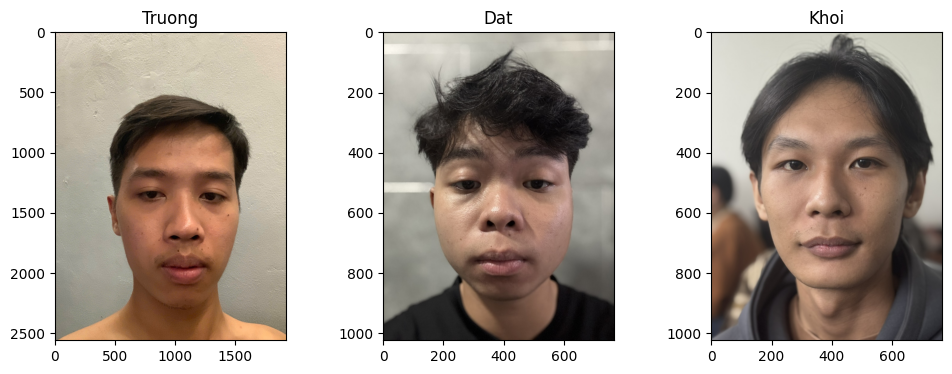

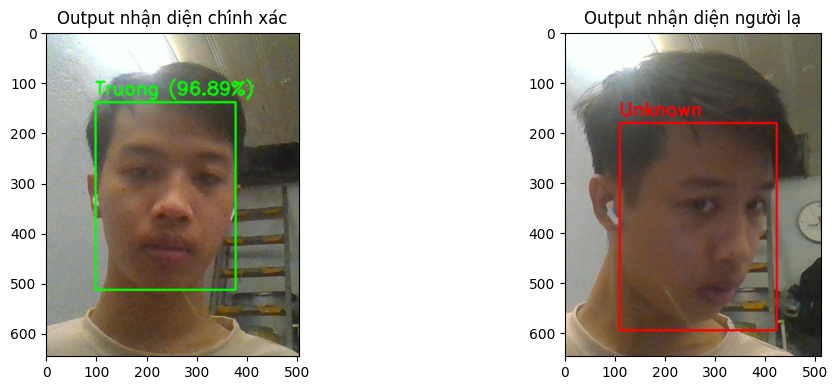

In [9]:
# Hiển thị một vài ảnh
ImageFile.LOAD_TRUNCATED_IMAGES = True

# mô tả ảnh input
img_truong = Image.open("C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset/Truong/z6620227836982_7b7b53906c53751379c8eb6358baca95.jpg")
img_dat = Image.open("C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset/Dat/Dat1.jpeg")
img_khoi = Image.open("C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset/Duy Khoi/khoi1.jpeg")

# ảnh output
img_truong_o1= Image.open("C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/code_final/Mota_ouput/mota_output1.png")
img_truong_02= Image.open("C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/code_final/Mota_ouput/mota_output2.png")

# Hiển thị ảnh input
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_truong)
plt.title("Truong")
plt.subplot(1, 3, 2)
plt.imshow(img_dat)
plt.title("Dat")
plt.subplot(1, 3, 3)
plt.imshow(img_khoi)
plt.title("Khoi")

# Hiển thị ảnh output
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_truong_o1)
plt.title("Output nhận diện chính xác")
plt.subplot(1, 2, 2)
plt.imshow(img_truong_02)
plt.title("Output nhận diện người lạ")

plt.tight_layout()
plt.show()

-----------------------------------------------------------------------------------------------------------------------


STEP 2: Data Understanding.

Mục đích: Hiểu rõ chất lượng đặc điểm và tiền xử lý dữ liệu ảnh

Bao gồm 
- Inconsistent: Tìm dữ liệu không nhất quán
- Data Overview: Kiểm tra tổng quan dữ liệu( số lượng ảnh và kích thước phổ biến)
- Imbalanced: Kiểm tra sự mất cân bằng giữa các lớp
- Data Augmentation : Tăng cường dữ liệu 


In [11]:
# kiểm tra file nào ko phải ảnh hoặc bị lỗi thì xóa

# duyệt từng tệp trong từng thư mục con của dataset
for person in os.listdir(dataset_path): 
    person_path = os.path.join(dataset_path, person)
    for img_file in os.listdir(person_path):
        img_path = os.path.join(person_path, img_file)
        # Thực hiện xác minh nếu ko phải là định dạng của ảnh thì thực hiện xóa 
        try:
            with Image.open(img_path) as img:
                img.verify()  # hàm xác minh ảnh
        except (UnidentifiedImageError, OSError):
            print(f"Ảnh lỗi: {img_path} \n -- Đang xóa...")
            os.remove(img_path)  # Xóa file  lỗi

Ảnh lỗi: C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset\An\.DS_Store 
 -- Đang xóa...
Ảnh lỗi: C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset\Anh\.DS_Store 
 -- Đang xóa...
Ảnh lỗi: C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset\Duc\.DS_Store 
 -- Đang xóa...
Ảnh lỗi: C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset\Duong\.DS_Store 
 -- Đang xóa...
Ảnh lỗi: C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset\Duy Khoi\.DS_Store 
 -- Đang xóa...
Ảnh lỗi: C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset\Ha\.DS_Store 
 -- Đang xóa...
Ảnh lỗi: C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset\Hieu\.DS_Store 
 -- Đang xóa...
Ảnh lỗi: C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset\Lam\.DS_Store 
 -- Đang xóa...
Ảnh lỗi: C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset\Long\.DS_Store 
 -- Đang xóa...
Ảnh lỗi: C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset\Luan\.DS_Store 
 -- Đang xóa...
Ảnh lỗi: C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset\

In [12]:
# kiểm tra số lượng ảnh và kích thước phổ biến
sizes = []
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    for img_file in os.listdir(person_path):
        img_path = os.path.join(person_path, img_file)
        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)
        except:
            pass  # Bỏ qua ảnh lỗi đã phát hiện ở trên

print("Số lượng ảnh:", len(sizes))
print("Kích thước phổ biến nhất:", max(set(sizes), key=sizes.count))

Số lượng ảnh: 783
Kích thước phổ biến nhất: (640, 480)


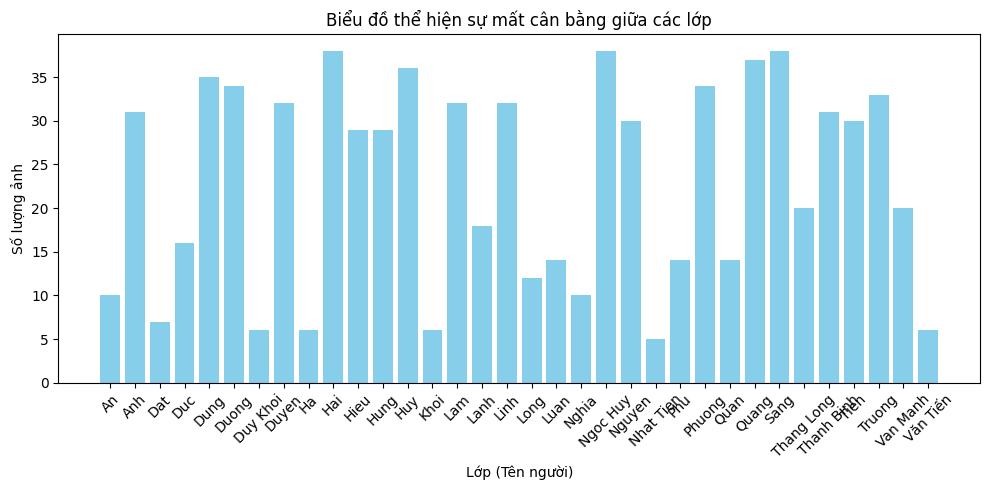

In [13]:
# Kiểm tra sự mất cân bằng giữa các lớp

class_counts = defaultdict(int)

# Đếm số lượng ảnh của mỗi lớp
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if os.path.isdir(person_path):
        for img_file in os.listdir(person_path):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                class_counts[person] += 1

# Vẽ biểu đồ cột
labels = list(class_counts.keys())
values = list(class_counts.values())

plt.figure(figsize=(10, 5))
plt.bar(labels, values, color='skyblue')
plt.xlabel("Lớp (Tên người)")
plt.ylabel("Số lượng ảnh")
plt.title("Biểu đồ thể hiện sự mất cân bằng giữa các lớp")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
# Tăng cường dữ liệu
# nếu người nào có số lượng ảnh dưới 30 thì tăng cường bằng các pp tcdl

min_images = 30  # Số ảnh tối thiểu cho mỗi lớp

def augment_image(img): # Các phương pháp tăng cường dữ liệu
    operations = [
        lambda x: x.rotate(15), # xoay phải 1 góc 15 độ
        lambda x: x.rotate(-15),# xoay trái 1 góc 15 độ
        lambda x: x.rotate(10), # xoay phải 10 độ
        lambda x: x.rotate(-10),# xoay trái 10 độ
        lambda x: ImageOps.mirror(x), # lật ngang
        lambda x: ImageEnhance.Brightness(x).enhance(1.5), # tăng độ sáng
        lambda x: ImageEnhance.Color(x).enhance(1.5), # tăng độ bão hòa
    ]
    op = random.choice(operations)
    return op(img)

for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if not os.path.isdir(person_path):
        continue

    # Đếm số ảnh hiện có
    imgs = [f for f in os.listdir(person_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    count = len(imgs)
    print(f"{person} hiện có {count} ảnh.")
    if count >= min_images:
        continue  # Không cần tăng cường
    # Tạo thêm ảnh để đủ min_images
    needed = min_images - count
    print(f"Tăng cường thêm {needed} ảnh cho lớp {person}.")

    for i in range(needed):
        # Chọn ngẫu nhiên 1 ảnh gốc để biến đổi
        orig_img_name = random.choice(imgs)
        orig_img_path = os.path.join(person_path, orig_img_name)
        with Image.open(orig_img_path) as img:
            aug_img = augment_image(img)
            # Lưu ảnh mới với tên mới
            new_img_name = f"aug_{i}_{orig_img_name}"
            new_img_path = os.path.join(person_path, new_img_name)
            aug_img.save(new_img_path)

print("Tăng cường dữ liệu hoàn tất.")


An hiện có 10 ảnh.
Tăng cường thêm 20 ảnh cho lớp An.


Anh hiện có 31 ảnh.
Dat hiện có 7 ảnh.
Tăng cường thêm 23 ảnh cho lớp Dat.
Duc hiện có 16 ảnh.
Tăng cường thêm 14 ảnh cho lớp Duc.
Dung hiện có 35 ảnh.
Duong hiện có 34 ảnh.
Duy Khoi hiện có 6 ảnh.
Tăng cường thêm 24 ảnh cho lớp Duy Khoi.
Duyen hiện có 32 ảnh.
Ha hiện có 6 ảnh.
Tăng cường thêm 24 ảnh cho lớp Ha.
Hai hiện có 38 ảnh.
Hieu hiện có 29 ảnh.
Tăng cường thêm 1 ảnh cho lớp Hieu.
Hung hiện có 29 ảnh.
Tăng cường thêm 1 ảnh cho lớp Hung.
Huy hiện có 36 ảnh.
Khoi hiện có 6 ảnh.
Tăng cường thêm 24 ảnh cho lớp Khoi.
Lam hiện có 32 ảnh.
Lanh hiện có 18 ảnh.
Tăng cường thêm 12 ảnh cho lớp Lanh.
Linh hiện có 32 ảnh.
Long hiện có 12 ảnh.
Tăng cường thêm 18 ảnh cho lớp Long.
Luan hiện có 14 ảnh.
Tăng cường thêm 16 ảnh cho lớp Luan.
Nghia hiện có 10 ảnh.
Tăng cường thêm 20 ảnh cho lớp Nghia.
Ngoc Huy hiện có 38 ảnh.
Nguyen hiện có 30 ảnh.
Nhat Tien hiện có 5 ảnh.
Tăng cường thêm 25 ảnh cho lớp Nhat Tien.
Phu hiện có 14 ảnh.
Tăng cường thêm 16 ảnh cho lớp Phu.
Phuong hiện có 34 ảnh.
Quan h

In [10]:
# khôi phục lại
import os

for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if not os.path.isdir(person_path):
        continue

    for img_file in os.listdir(person_path):
        if img_file.startswith("aug_"):
            img_path = os.path.join(person_path, img_file)
            os.remove(img_path)

print("Đã khôi phục lại dữ liệu ban đầu (đã xóa các ảnh tăng cường).")

Đã khôi phục lại dữ liệu ban đầu (đã xóa các ảnh tăng cường).


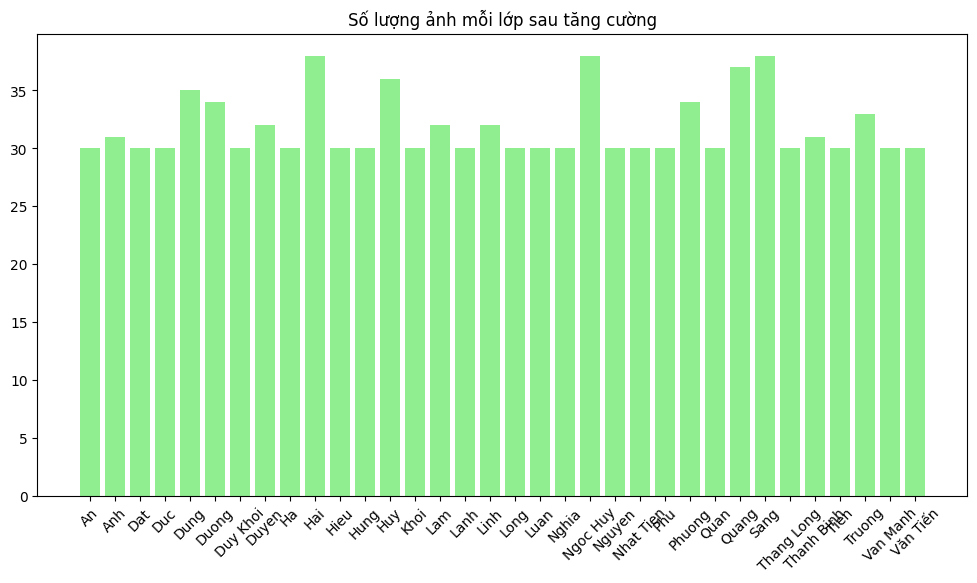

In [180]:
# Kiểm tra lại sự mất cân bằng của các lớp
class_counts = defaultdict(int)
for person in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person)
    if os.path.isdir(person_path):
        class_counts[person] = len([f for f in os.listdir(person_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='lightgreen')
plt.xticks(rotation=45)
plt.title("Số lượng ảnh mỗi lớp sau tăng cường")
plt.show()

--------------------------------------------------------------------------------------------------------------------------

Step 3. Feature Understanding

Mục đích: Thực hiện trích xuất đặc trưng và Khám phá mối quan hệ giữa các biến

Thực hiện trích xuất đặc trưng


Multivariate: Phân tích mối quan hệ đa biến (UMAP)



In [15]:
# Trích xuất đặc trưng bằng FaceNet với dataset đã xử lý

# cài đặt thiết bị: ưu tiên sử dụng gpu nếu ko thì sd cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Khởi tạo MTCNN và FaceNet

# mtcnn: mô hình phát hiện khuôn mặt 
mtcnn = MTCNN(image_size=160, margin=20, device=device)
# facenet mô hình nhận dạng khuôn mặt ( dưới dạng đặc trưng với vector 512 chiều)
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Đường dẫn dữ liệu và nơi lưu đặc trưng
data_root = "C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/dataset"
save_root = "C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/saved_embeddings"
os.makedirs(save_root, exist_ok=True)

# Duyệt từng thư mục người
for person_name in os.listdir(data_root):
    person_folder = os.path.join(data_root, person_name)
    if not os.path.isdir(person_folder) or person_name.startswith('.'):
        continue

# lưu đặc trưng và nhãn
    embeddings = []
    labels = []
# duyệt từng ảnh và chuyển hóa 
    print(f"Đang xử lý: {person_name}")
    for filename in os.listdir(person_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(person_folder, filename)
            try:
                img = Image.open(img_path)
                if img.mode != 'RGB':
                    img = img.convert("RGB")

                # Trích xuất đặc trưng
                # Phát hiện khuôn mặt
                face = mtcnn(img)
                
                if face is not None:                        # nếu phát hiện dc khuôn mặt
                    face = face.unsqueeze(0).to(device)     # đưa vào facenet thực hiện thêm patch, r đưa tenso len gpu
                    with torch.no_grad():                   # ko cần huấn luyện, chỉ cần trích xuất nên vô hiệu hóa gradient
                        emb = facenet(face).cpu().numpy()   # lấy embedding, chuyển về cpu với dạng mảng numpy
                    embeddings.append(emb[0])               # thêm vecto kích thước vào đặc trưng
                    labels.append(person_name)              # gán nhãn
                else:
                    print(f" Không nhận diện được khuôn mặt: {filename} ({person_name})")

            except Exception as e:
                print(f" Lỗi khi mở ảnh {filename}: {e}")

    if embeddings:
        save_path = os.path.join(save_root, f"{person_name}.npz")
        np.savez(save_path, features=np.array(embeddings), labels=np.array(labels))
        print(f" Đã lưu đặc trưng của {person_name} vào {save_path}")
    else:
        print(f" Không có đặc trưng nào được trích từ {person_name}")

Đang xử lý: An
 Đã lưu đặc trưng của An vào C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/saved_embeddings\An.npz
Đang xử lý: Anh
 Đã lưu đặc trưng của Anh vào C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/saved_embeddings\Anh.npz
Đang xử lý: Dat
 Đã lưu đặc trưng của Dat vào C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/saved_embeddings\Dat.npz
Đang xử lý: Duc
 Đã lưu đặc trưng của Duc vào C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/saved_embeddings\Duc.npz
Đang xử lý: Dung
 Đã lưu đặc trưng của Dung vào C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/saved_embeddings\Dung.npz
Đang xử lý: Duong
 Đã lưu đặc trưng của Duong vào C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/saved_embeddings\Duong.npz
Đang xử lý: Duy Khoi
 Đã lưu đặc trưng của Duy Khoi vào C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/saved_embeddings\Duy Khoi.npz
Đang xử lý: Duyen
 Đã lưu đặc trưng của Duyen vào C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/saved_embeddings\Duyen.npz
Đang 

------------------------------------------------------------------------------------------------------------------------

STEP 4: Feature Engineering ( Kỹ thuật đặc trưng )
Chuẩn bị và biến đổi dữ liệu đầu vào thành dạng tốt nhất cho mô hình học máy.

Bao gồm các bước:

+ [KHÔNG CẦN THIẾT] 
-  Missing Values và Outlier Handling : từ bước đầu đã xử lý và loại bỏ các tệp ko phải ảnh rồi, mỗi ảnh sẽ chỉ trích xuất ra 1 vecto đặc trưng nên đã được chuẩn hóa và nhất quán.
-  Inconsistent ( Giá trị không nhất quán) : embedding là đầu ra đã được đảm bảo tính nhất quán (1:1); dl ảnh ko như dữ liệu text hay tabular, hai dạng này hay gặp lỗi không nhất quán như: (Nam/Nam giới/Male)

-  Skewness: (Độ lệch phân phối)  Vì embedding không phải là dữ liệu dạng tabular ( tuổi tác...)
phân phối có thể ko theo chuẩn vì đã học dc ko gian biểu diễn tối ưu ( thậm chí ép log, sqrt có thể phá hỏng đặc trưng đã học)


- Feature Selection (PCA) quá trình chọn ra những đặc trưng quan trọng nhất, loại bỏ các chiều dư thừa hoặc ít thông tin, nhưng vì dataset có ít dữ liệu nên nếu giảm chiều có thể làm mất các đặc trưng quan trọng sẽ bị ảnh hưởng đến độ chính xác và kết quả nhận dạng.


- Feature Transformation: là quá trình biến đổi đặc trưng theo các hàm toán học để dễ mô hình hóa hơn, tăng khả năng phân biệt giữa các lớp. 

Nhưng Embedding của FaceNet đã được học phi tuyến và tối ưu, có L2-normalized sẵn......Các phép biến đổi như log/sqrt/polynomial sẽ làm méo không gian đặc trưng, gây sai lệch 



+ [ CẦN THIẾT]

- Label Encoding: Biến đổi nhãn dạng text (chuỗi) như tên người → thành dạng số nguyên để mô hình học được dễ dàng hơn.

- One-hot Encoding: là 1 cách biểu diễn nhãn dưới dạng vecto nhị phân [0,1]

- Feature Scaling: Normalization (Chuẩn hóa)  L2-normalized là quá trình biến đổi các đặc trưng sao cho chúng nằm trong một khoảng giá trị chuẩn , giúp mô hình học máy xử lý tốt hơn.




In [5]:
# Thêm label encoding 
all_labels = []
save_label= "C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/code_final" 
# Duyệt qua các file npz để gom nhãn
for file in os.listdir(embedding_dir):
    if file.endswith(".npz"):
        data = np.load(os.path.join(embedding_dir, file))
        labels = data['labels']
        all_labels.extend(labels.tolist())

# Label Encoding
le = LabelEncoder()
encoded_labels = le.fit_transform(all_labels)

print(f"Tổng số nhãn: {len(all_labels)}")
print(f"Số lớp (số người): {len(le.classes_)}")
print(f"Ví dụ mã hóa: {list(zip(all_labels[:5], encoded_labels[:5]))}")

# Lưu LabelEncoder để sử dụng lại về sau
with open(os.path.join(save_label, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)

print("Đã lưu LabelEncoder vào file label_encoder.pkl")


Tổng số nhãn: 1118
Số lớp (số người): 36
Ví dụ mã hóa: [('An', 0), ('An', 0), ('An', 0), ('An', 0), ('An', 0)]
Đã lưu LabelEncoder vào file label_encoder.pkl


Feature Scaling: Normalization (Chuẩn hóa)

In [7]:
# kiểm tra xem L2 - nomalize có chưa
norms = np.linalg.norm(all_embeddings, axis=1)
print("L2-normalize : ", np.mean(norms))  # Kết quả đã chuẩn hóa


L2-normalize :  1.0


-------------------------------------------------------------------------------------------------------------------------

STEP 5 : Dataset Partition
Mục đích: Chia dữ liệu để huấn luyện và đánh giá

Imbalanced Handling: Xử lý mất cân bằng dữ liệu (SMOTE, undersampling) : khoog cần thiết bởi vì ở bước tiền xử lý ảnh, dữ liệu đã được cân bằng khá tốt r, ko có sự chênh lệch quá nhiều.

Train Test Split: Chia dữ liệu thành tập huấn luyện và kiểm tra


In [8]:
# CHIA TẠP DỮ LIỆU
# Danh sách đặc trưng train và test
train_embeddings, train_labels = [], []
test_embeddings, test_labels = [], []

# Duyệt qua các file .npz
for file in os.listdir(embedding_dir):
    if file.endswith(".npz"):
        path = os.path.join(embedding_dir, file)
        data = np.load(path)
        features = data["features"]
        labels = data["labels"]
        n = len(features)

        # Shuffle ngẫu nhiên
        idx = list(range(n))
        random.shuffle(idx)

        # Tính số lượng test = 30%
        num_test = max(1, int(n * 0.30))
        test_idx = idx[:num_test]
        train_idx = idx[num_test:]

        # Tách vecto đặc trưng ( để đưa vào train và test)
        test_embeddings.append(features[test_idx])
        test_labels.append(labels[test_idx])
        train_embeddings.append(features[train_idx])
        train_labels.append(labels[train_idx])

# Gộp đặc trưng và nhãn lại
X_train = np.vstack(train_embeddings)
y_train = np.concatenate(train_labels)
X_test = np.vstack(test_embeddings)
y_test = np.concatenate(test_labels)

# Lưu kết quả
save_dir = "C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/code_final/data_split"  
os.makedirs(save_dir, exist_ok=True)

np.savez(os.path.join(save_dir, "train_embeddings.npz"), features=X_train, labels=y_train)
np.savez(os.path.join(save_dir, "test_embeddings.npz"), features=X_test, labels=y_test)

print(f" Đã chia dữ liệu")
print(f"Train samples: {len(X_train)}")
print(f"Test samples : {len(X_test)}")
print(f"Đã lưu tại: {save_dir}")


 Đã chia dữ liệu
Train samples: 791
Test samples : 327
Đã lưu tại: C:/Users/Loc/Desktop/Do_An_Co_So/Do_An_Co_So/code/code_final/data_split


--------------------------------------------------------------------------------------------------------------------------

Step 6. Data Modelling

Mục đích: Thử nghiệm các thuật toán ML khác nhau

Machine Learning methods:  (Random Forest, SVM, LogisticRegression)

Deep Learning methods:  (MobileNetv2, ResNet, FaceNet, CNN )

So sánh hiệu suất của các models